In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
def save_notebook():
    return display(Javascript("IPython.notebook.save_notebook()"),
                   include=['application/javascript'])

def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [3]:
import sys, os
import glob
import warnings
from itertools import cycle
sys.path.append('../')

from rankutils.evaluation import comp_precision, comp_recall, interp_prec_recall_curve

from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import mpld3
#sns.set()

from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange

pmarkers = cycle(['o', 'v', '^', 'p', 'P', '*', 'h', 'D', 'x'])

np.set_printoptions(suppress=True, precision=3, linewidth=300, formatter=dict(float="{0:0.4f}"))

In [4]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    if val < 0:
        color = 'red' 
    elif val > 0:
        color = 'blue'
    else:
        color = 'black'
    return 'color: %s' % color

In [5]:
def make_header_label(header):
    
    dataset = header['dataset']
    method = header['method']
    topn = header['topn']
    k = header['k']
    label = header['labelfolder']
    phi = header['phi']
    balance = header['balance']
    
    prefix = "{0:s} {1:s}".format(dataset, method)
    if len(str(method).split('_')) > 1:        
        label = "{0:25s} [{1:s}][n = {2:03d} | k = {3:03d} | phi = {4:0.2f}".format(prefix, label, topn, k, phi)
        if balance:
            label += " | b = {0:d}".format(balance)
        label += "]"
        
    else:
        label = "{0:25s} [n = {1:03d}]".format(prefix, topn)
    
    return label

In [6]:
def eval_elp_precision_recall(labels, k):
    
    assert labels.shape[1] >= k, "The number of positions labeled for each rank <{0:d}> should be >= k <{1:d}>".format(labels.shape[1], k)
    
    elp_rec = np.arange(0.0, 1.1, 0.1)
    elp_prec_all = []
    ap_all = np.zeros(labels.shape[0], dtype=np.float64)

    for i, row in enumerate(labels):
        
        y_true = row[0:k]
        
        if y_true.sum() > 0:

            prec = comp_precision(y_true)
            rec = comp_recall(y_true)

            elp_prec_all.append(interp_prec_recall_curve(prec, rec, points=elp_rec))

            ap_all[i] = average_precision_score(y_true, np.arange(y_true.size, 0, -1))
        else:
            aux = np.zeros(11, dtype=np.float64)
            aux[0] = 1.0
            elp_prec_all.append(aux)

    elp_prec_all = np.vstack(elp_prec_all)

    mean_elp_prec = np.mean(elp_prec_all, axis=0)
    
    return mean_elp_prec, np.mean(ap_all), ap_all

In [7]:
def load_pathlists(collection, get_bsl=[]):
    
    # Baseline Labels
    bsl_labeldir = '/home/alberto/phD/projects/performance_prediction/ret-mr-learning/input-labels/{0:s}/'.format(collection)
    aux = glob.glob(bsl_labeldir + "*.npy")
    aux.sort()
    if get_bsl:
        bsl_labelpaths = []
        for i in get_bsl:
            bsl_labelpaths.append(aux[i])
    else:
        bsl_labelpaths = aux

    # Aggregated Labels
    agg_labeldir = '/home/alberto/phD/projects/performance_prediction/ret-mr-learning/output-agg/eval/'.format(collection)
    agg_labelpaths = glob.glob(agg_labeldir + "*.npz")
    agg_labelpaths.sort()
    
    return bsl_labelpaths, agg_labelpaths

In [8]:
topk = 50
collection = 'places365'

leg_name_map = dict()

if collection == 'vggfaces':
    bsl_labelpaths, agg_labelpaths = load_pathlists(collection, get_bsl=[0, 2, 3, 4])
else:
    bsl_labelpaths, agg_labelpaths = load_pathlists(collection)

np.set_printoptions(precision=3, suppress=True)

In [9]:
# bsl_namelist = [[], []]
# bsl_eval = [[], []]

# min_mAP = np.inf
# max_mAP = -np.inf

# ap_all_list = []

# # Evaluating the baselines. Retains only the methods with max and min mAP
# for path in tqdm(bsl_labelpaths, desc="Evaluating baselines: ", total=len(bsl_labelpaths)):
    
#     mean_elp_prec, mAP, ap_all = eval_elp_precision_recall(np.load(path), topk)
#     ap_all_list.append(ap_all.reshape(-1, 1))
    
#     if mAP < min_mAP:
#         bsl_eval[0] = mean_elp_prec
#         aux = os.path.basename(path).rsplit('.', 2)[0]
#         bsl_namelist[0] = "{0:85s} : mAP = {1:0.3f} [MIN]".format(aux, mAP)
#         min_mAP = mAP
    
#     if mAP > max_mAP:
#         bsl_eval[1] = mean_elp_prec
#         aux = os.path.basename(path).rsplit('.', 2)[0]
#         bsl_namelist[1] = "{0:85s} : mAP = {1:0.3f} [MAX]".format(aux, mAP)
#         max_mAP = mAP

In [10]:
bsl_namelist = []
bsl_eval = []

min_mAP = np.inf
max_mAP = -np.inf

ap_all_list = []


for path in tqdm(bsl_labelpaths, desc="Evaluating baselines: ", total=len(bsl_labelpaths)):
    
    mean_elp_prec, mAP, ap_all = eval_elp_precision_recall(np.load(path), topk)
    ap_all_list.append(ap_all.reshape(-1, 1))
    
    bsl_eval.append(mean_elp_prec)
    aux = os.path.basename(path).rsplit('.', 2)[0]
    bsl_namelist.append("{0:85s} : mAP = {1:0.3f}".format(aux, mAP))

In [11]:
agg_namelist = []
agg_eval = []

for path in tqdm(agg_labelpaths, desc="Evaluating additionals: ", total=len(agg_labelpaths)):
    
    try:
        a = np.load(path)
        
        
        mean_elp_prec, mAP, ap_all = eval_elp_precision_recall(a['labels'], topk)
        agg_eval.append(mean_elp_prec)
        ap_all_list.append(ap_all.reshape(-1, 1))

        aux = os.path.basename(path).rsplit('.', 1)[0]
        agg_namelist.append("{0:85s} : mAP = {1:0.3f}".format(make_header_label(a['header']), mAP))
    except AssertionError:
        pass

places365.001.vgg16-L2sq                                                              : mAP = 0.574
places365.002.resnet152-L2sq                                                          : mAP = 0.580
places365.003.vgg16-Cos                                                               : mAP = 0.598
places365.004.vgg16-Cheby                                                             : mAP = 0.578
places365.005.vgg16-Canb                                                              : mAP = 0.579
places365 combSUM         [n = 050]                                                   : mAP = 0.572
places365 combSUM_pre     [pred0009][n = 050 | k = 050 | phi = 0.99]                  : mAP = 0.564


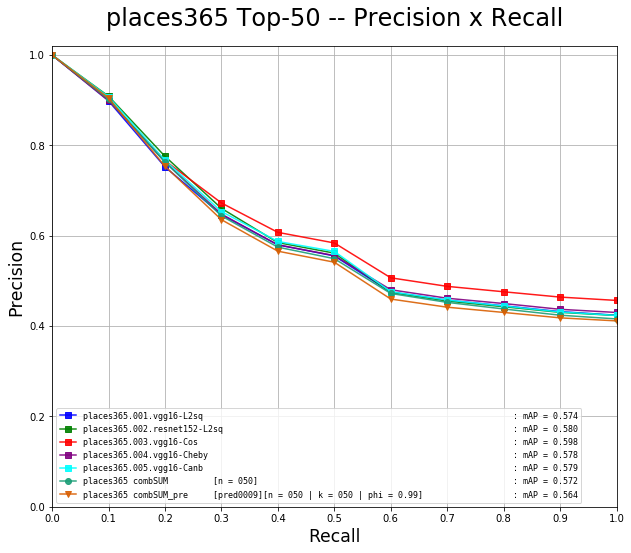

In [12]:
for n in bsl_namelist:
    print(n)
    
for n in agg_namelist:
    print(n)

# changing the legend entry order
#order = [2, 0, 1, 3, 4, 5]
#order = [3, 0, 1, 2]
order = range(len(agg_namelist))
    
fig, ax = plt.subplots()
fig.set_size_inches(9, 8)
fig.tight_layout()

x = np.arange(0.0, 1.1, 0.1)

# Drawing Baselines

bsl_c = ['blue', 'green', 'red', 'purple', 'cyan']

for i in range(len(bsl_eval)):
    ax.plot(x, bsl_eval[i], '-s', color=bsl_c[i], label="{0:s}".format(bsl_namelist[i]), alpha=0.9)

c = cycle(plt.get_cmap('Dark2').colors)
for i in order:
    y = agg_eval[i]
    
    if agg_namelist[i] in leg_name_map:
        l = leg_name_map[agg_namelist[i]]
    else:
        l = agg_namelist[i]
    
    ax.plot(x, y, '-', color=next(c), label="{0:85s}".format(l), marker=next(pmarkers), alpha=0.9)


ax.set_xlim(0.0, 1.0)
ax.set_xlabel('Recall', **dict(fontsize='xx-large'))
ax.set_xticks(np.arange(0.0, 1.1, 0.1))

ax.set_ylim(0.0, 1.02)
ax.set_ylabel('Precision', **dict(fontsize='xx-large'))

ax.grid(which='both', axis='both')

ax.set_title('{0:s} Top-{1:d} -- Precision x Recall'.format(collection, topk), **dict(fontsize=24), pad=20)

legend = ax.legend(prop={'family':'monospace', 'size':'small'})

plt.subplots_adjust(left=0.1, top=0.9, bottom=0.1)
#mpld3.enable_notebook()
plt.savefig('/home/alberto/phD/projects/evaluation/rank-aggregation+irp/varf_{0:s}_top{1:d}_PxR.png'.format(collection, topk), dpi=300)

In [13]:
def compare_ap(ap_all, name_a, idx_a, name_b, idx_b):
    
    import pandas
    
    data = {'{0:s} AP'.format(name_a):[],
            '{0:s} AP'.format(name_b):[],
            'Gain':[],
            '% Gain':[]}
    
    for i, row in enumerate(ap_all):
        data['{0:s} AP'.format(name_a)].append(row[idx_a])
        data['{0:s} AP'.format(name_b)].append(row[idx_b])
        data['Gain'].append(row[idx_b] - row[idx_a])
        data['% Gain'].append(((row[idx_b] - row[idx_a])/row[idx_a])*100)
        
    pandas.options.display.float_format = '{:.4f}'.format
            
    df = pandas.DataFrame(data)
    
    return df
    
idx_a = 4
idx_b = 5
#df = compare_ap(np.hstack(ap_all_list), 'combSUM', 4, 'combSUM_pre', 6)
df = compare_ap(np.hstack(ap_all_list), 'resnet152', 1, 'vgg16-Cos', 2)
print(df.describe())
df[df['% Gain'] > 10].style.applymap(color_negative_red, subset=['Gain', '% Gain'])

       resnet152 AP  vgg16-Cos AP      Gain    % Gain
count     3650.0000     3650.0000 3650.0000 3650.0000
mean         0.5804        0.5982    0.0178   12.3221
std          0.2348        0.2339    0.2392   47.2214
min          0.2050        0.2075   -0.7452  -74.5213
25%          0.3864        0.3979   -0.0849  -16.3766
50%          0.5238        0.5385    0.0196    3.5551
75%          0.7538        0.7902    0.1424   31.9493
max          1.0000        1.0000    0.7632  322.3368


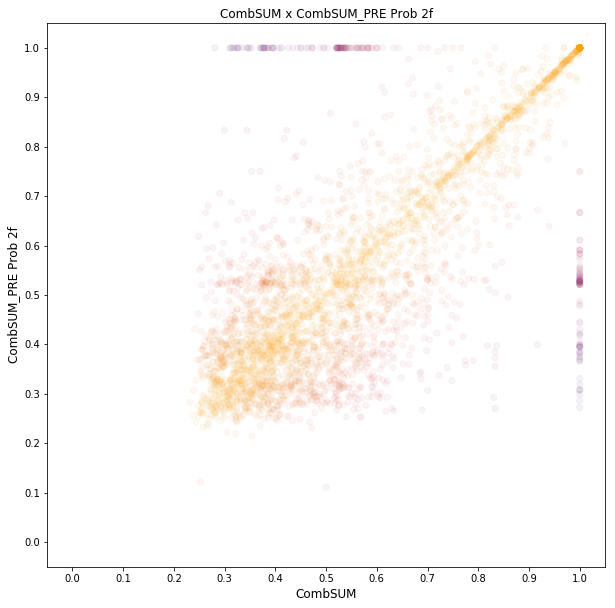

In [14]:
from rankutils.drawing import colors_from_cmap

def draw_corr_map(ap_all, name_a, idx_a, name_b, idx_b, ax):
    
    ax.set_title("{0:s} x {1:s}".format(name_a, name_b))
    
    x = ap_all[:, idx_a]
    y = ap_all[:, idx_b]
    
    ax.scatter(x, y, marker='o', color=colors_from_cmap('inferno', 1 - np.abs(x-y), bounds=(0.2, 0.8)), alpha=0.05)
    
    ax.set_ylim(bottom=-0.05, top=1.05)
    ax.set_yticks([y for y in np.arange(0, 1.1, 0.1)])
    ax.set_ylabel(name_b, fontdict=dict(fontsize=12))

    ax.set_xlim(left=-0.05, right=1.05)
    ax.set_xticks([x for x in np.arange(0, 1.1, 0.1)])
    ax.set_xlabel(name_a, fontdict=dict(fontsize=12))
    
fig, ax = plt.subplots(1)
fig.set_size_inches((10, 10))
                    
draw_corr_map(np.hstack(ap_all_list), 'CombSUM', 5, 'CombSUM_PRE Prob 2f', 6, ax)